In [ ]:
!pip install pykalman
!pip install ffn


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import yfinance as yf
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')
from itertools import product

In [ ]:
start = datetime(2010, 1, 1)
end = datetime(2020, 1, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers, start, end)['Close']
df = df.dropna()

[*********************100%***********************]  2 of 2 completed


1761
1761
2264
2516


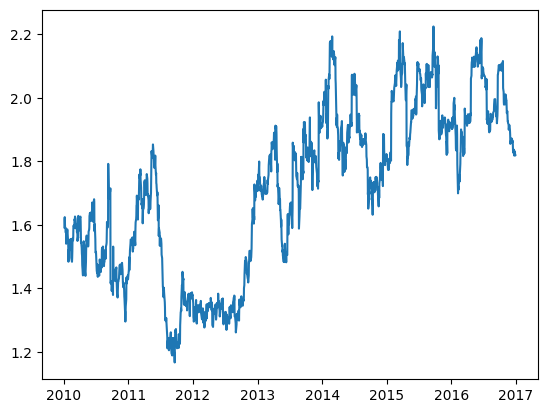

In [ ]:
ratio=df['ADBE']/df['MSFT']
train_test_ratio= round(len(ratio)*0.7)
print(train_test_ratio)

test_start= round(len(ratio)*0.7)
val_start= round(len(ratio)*0.9)
print(test_start)
print(val_start)
print(len(ratio))

train= ratio[:train_test_ratio]
test= ratio[train_test_ratio:val_start]
OS= ratio[val_start:]

x = df['ADBE']
y = df['MSFT']

train_x = x[:test_start]
train_y = y[:test_start]

test_x = x[test_start:val_start]
test_y = y[test_start:val_start]

val_x = x[val_start:]
val_y = y[val_start:]


plt.plot(train)
plt.show()

In [ ]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means


def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife


In [ ]:
regression_results = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))

a_estimate = regression_results[:, 0]  # Slope (alpha)
b_estimate = regression_results[:, 1]  # Intercept (beta)

# Print the last estimates for slope and intercept
print(f"Estimated slope (a): {a_estimate[-1]:.4f}")
print(f"Estimated intercept (b): {b_estimate[-1]:.4f}")


Estimated slope (a): 0.4610
Estimated intercept (b): 0.7122


In [ ]:
spread = y - (a_estimate + x*b_estimate)
spread_mean =  spread.mean()
spread_std = spread.std()


In [ ]:
k=1
movavg=train.rolling(window=20, center= False).mean()

#calculating standard deviation (volatility)
std=train.rolling(window=20, center=False).std()

upper_band= movavg + (k*std)
lower_band= movavg - (k*std)

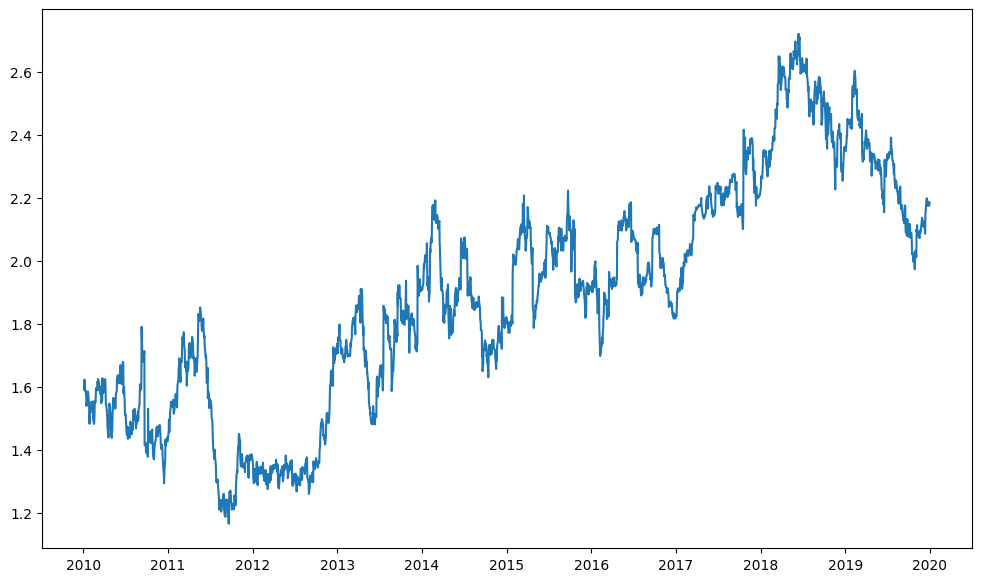

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(ratio, label='Ratio')
buy = train.copy()
sell = train.copy()
buy[train>lower_band] = 0
sell[train<upper_band] = 0

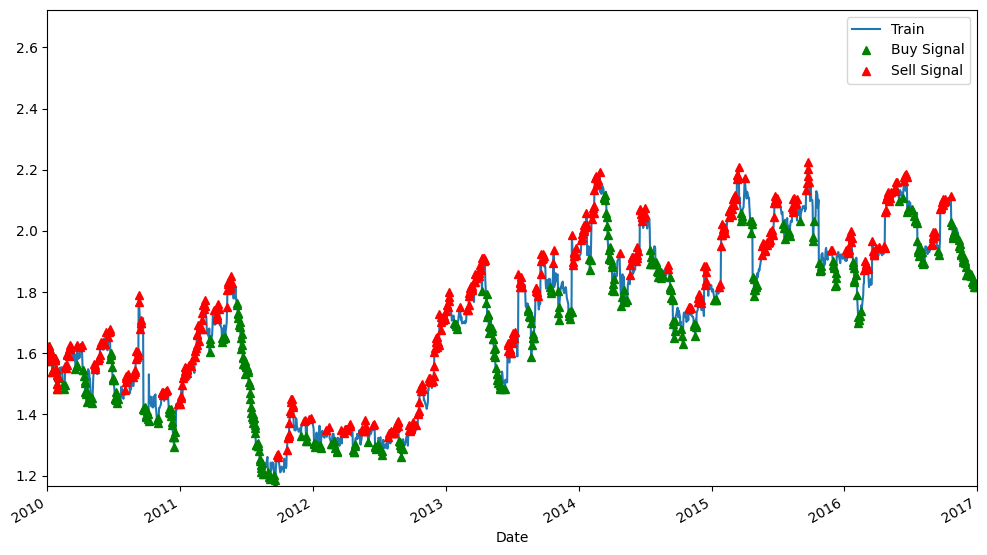

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(train, label='ratio')

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.xlim('2010-01-01','2017-01-01')
plt.legend(['Train', 'Buy Signal', 'Sell Signal'])
plt.show()

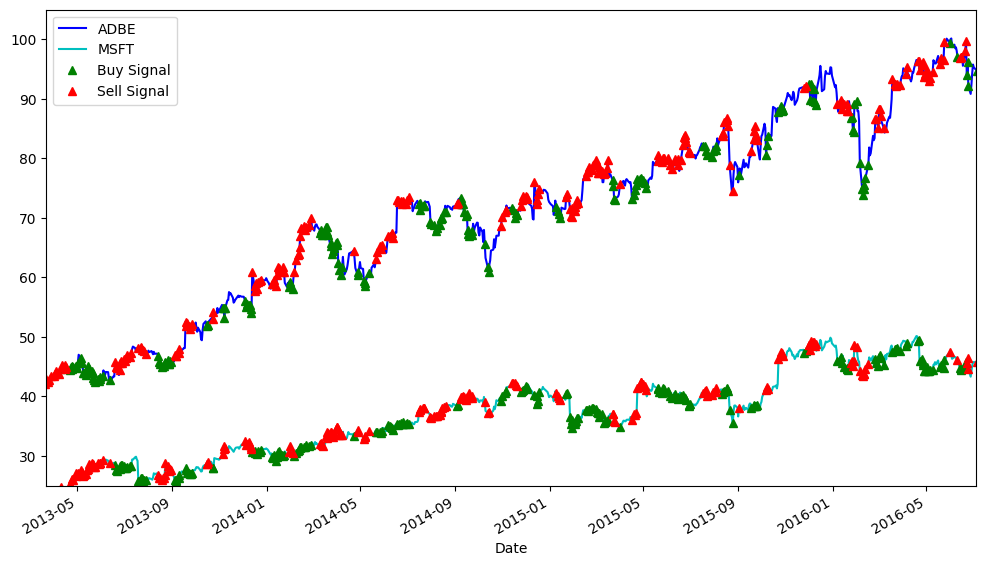

In [ ]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:1761]
S2 = df['MSFT'].iloc[:1761]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
threshold=0.8

def trade(S1, S2, window, k, risk_percentage, prev_moni):
    if window == 0 or window >= len(S1):
        return 0, 0  # Return profit and empty trades list

    ratio = S1 / S2

    df1 = pd.DataFrame({'y':S2,'x':S1})
    state_means = KalmanFilterRegression(KalmanFilterAverage(df1['x']),KalmanFilterAverage(df1['y']))

    df1['hr'] = - state_means[:,0]
    df1['bee'] = -state_means[:,1]
    df1['spread'] = df1.y + (df1.x * df1['hr']) + (df1['bee'])

    ma = df1.spread.rolling(window=window).mean()
    std = df1.spread.rolling(window=window).std()
    upper_band = ma + (k * std)
    lower_band = ma - (k * std)
    upper_band_soft = ma + (threshold*k*std)
    lower_band_soft = ma - (threshold*k*std)

    money = prev_moni
    countS1 = 0
    countS2 = 0
    trades = []
    daily_moni =[]
    position_size = 1
    for i in range(len(ratio)):
        if np.isnan(ma.iloc[i]) or np.isnan(std.iloc[i]):
            daily_moni.append(0)  # Append current money for days with NaN values
            continue

        # Trading logic
        if df1['spread'].iloc[i] > upper_band.iloc[i]:
            money += position_size * (S1.iloc[i] - S2.iloc[i])
            daily_moni.append(position_size * (S1.iloc[i] - S2.iloc[i]))
            countS1 -= position_size
            countS2 += position_size * ratio.iloc[i]
            position_size=max(1,risk_percentage*money/(S1.iloc[i] + S2.iloc[i]))

        elif df1['spread'].iloc[i] < lower_band.iloc[i]:
            money -= position_size * (S1.iloc[i] - S2.iloc[i])
            daily_moni.append(-position_size * (S1.iloc[i] - S2.iloc[i]))
            countS1 += position_size
            countS2 -= position_size * ratio.iloc[i]
            position_size=max(1,risk_percentage*money/(S1.iloc[i] + S2.iloc[i]))

        elif lower_band_soft.iloc[i] <= df1['spread'].iloc[i] <= upper_band_soft.iloc[i]:
            money += S1.iloc[i] * countS1 + S2.iloc[i] * countS2
            daily_moni.append(S1.iloc[i] * countS1 + S2.iloc[i] * countS2)
            trades.append((S1.iloc[i] * countS1) + (S2.iloc[i] * countS2))
            countS1 = 0
            countS2 = 0
            position_size=max(1,risk_percentage*money/(S1.iloc[i] + S2.iloc[i]))

        else:
          daily_moni.append(0)
          continue
    return money, trades, daily_moni




Total Profit: 5691.175635449592
Daily Sharpe Ratio: 0.70
Win Rate: 30.52%
Maximum Drawdown: 1840.367202366674


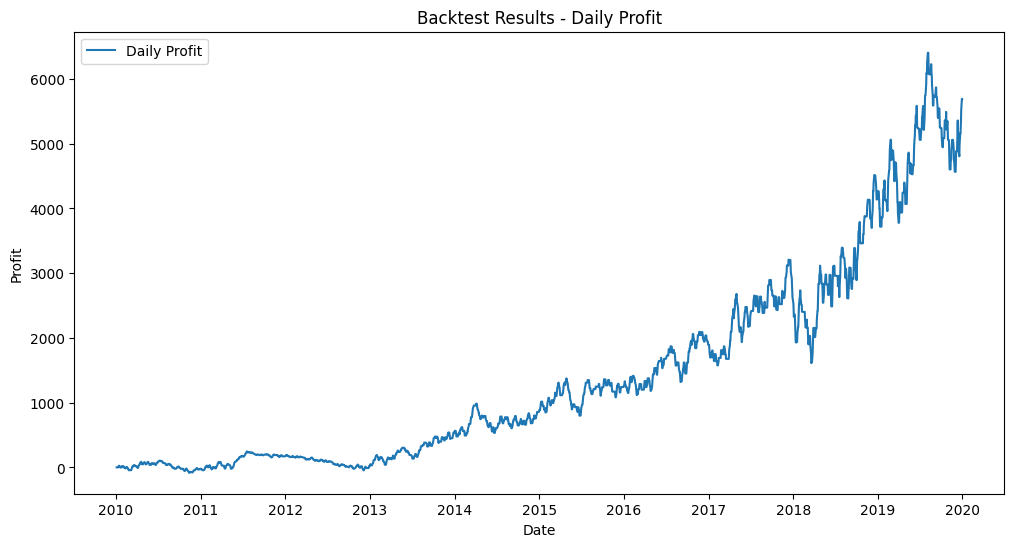

In [ ]:
def backtest(S1, S2, k, risk_percentage, smol):
    all_daily_profits = []  # List to store all daily profits
    start_dates = []  # List to store corresponding start dates
    prev_moni=0

    for start in range(1):
        end = start + len(S1)
        profit_plus, trades_list, daily_money = trade(S1.iloc[start:end], S2.iloc[start:end], smol, k, risk_percentage,prev_moni)
        prev_moni=profit_plus
        all_daily_profits.extend(daily_money)  # Add daily profits to the list
        start_dates.extend(S1.index[start:end])  # Add corresponding dates

    # Create a DataFrame with daily profits and dates
    daily_profit_df = pd.DataFrame({'Date': start_dates, 'Daily Profit': all_daily_profits})
    daily_profit_df.set_index('Date', inplace=True)  # Set 'Date' as index
    return daily_profit_df

# Performance evaluation function
def evaluate_performance(results):
    if isinstance(results, pd.DataFrame):
        # Total Profit
        total_profit = results['Daily Profit'].sum()

        # Daily Sharpe Ratio (assuming 252 trading days per year)
        daily_sharpe_ratio = results['Daily Profit'].mean() / results['Daily Profit'].std() * np.sqrt(252)

        # Win Ratio
        win_rate = len(results[results['Daily Profit'] > 0]) / len(results)

        # Maximum Drawdown
        cumulative_profit = results['Daily Profit'].cumsum()
        peak = cumulative_profit.cummax()
        drawdown = peak - cumulative_profit
        max_drawdown = drawdown.max()

        # Print performance metrics
        print(f"Total Profit: {total_profit}")
        print(f"Daily Sharpe Ratio: {daily_sharpe_ratio:.2f}")
        print(f"Win Rate: {win_rate * 100:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown}")
    else:
        print("Results are not in the expected format (DataFrame).")


# Define parameters
k = 1  # Best k from optimization
risk_percentage = 0.0  # Risk 1% of capital per trade
smol = 6

# Backtest the strategy
backtest_results = backtest(x, y, k, risk_percentage, smol)

# Evaluate performance
evaluate_performance(backtest_results)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Daily Profit'].cumsum(), label='Daily Profit')
plt.title('Backtest Results - Daily Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()


optimized parameters

In [ ]:
length_scores = [trade(train_x, train_y, l, k_val, r_val, 0)[0] for l in range(10, 250, 50) for k_val in np.arange(0.6, 1.8, 0.3) for r_val in np.arange(0.01, 0.15, 0.05)] # Only take the first element of the return value of the trade function (which is the profit)
best_length = np.argmax(length_scores) + 1  # Ensure non-zero window
print('Best window length:', best_length)

length_scores2 = [trade(test_x, test_y, l, k_val, r_val, 0)[0] for l in range(10, 250, 50) for k_val in np.arange(0.6, 1.8, 0.3) for r_val in np.arange(0.01, 0.15, 0.05)] # Only take the first element of the return value of the trade function (which is the profit)
best_length2 = np.argmax(length_scores2) + 1
print('Best test set window:', best_length2, 'Score:', length_scores2[best_length2 - 1])

Best window length: 6
Best test set window: 36 Score: 7983.157447520992
